# GP Classifier Sim+ vs Real+

In [23]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, draw_density_ratio_GP, refine_sample_GP, refine_sample2_GP

mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN, train_network, save_model_info, load_model_info

from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, refine_sample_GP

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from utils import load_item, show_grasp, count_real_positives

torch.manual_seed(42)


sim2real!!!


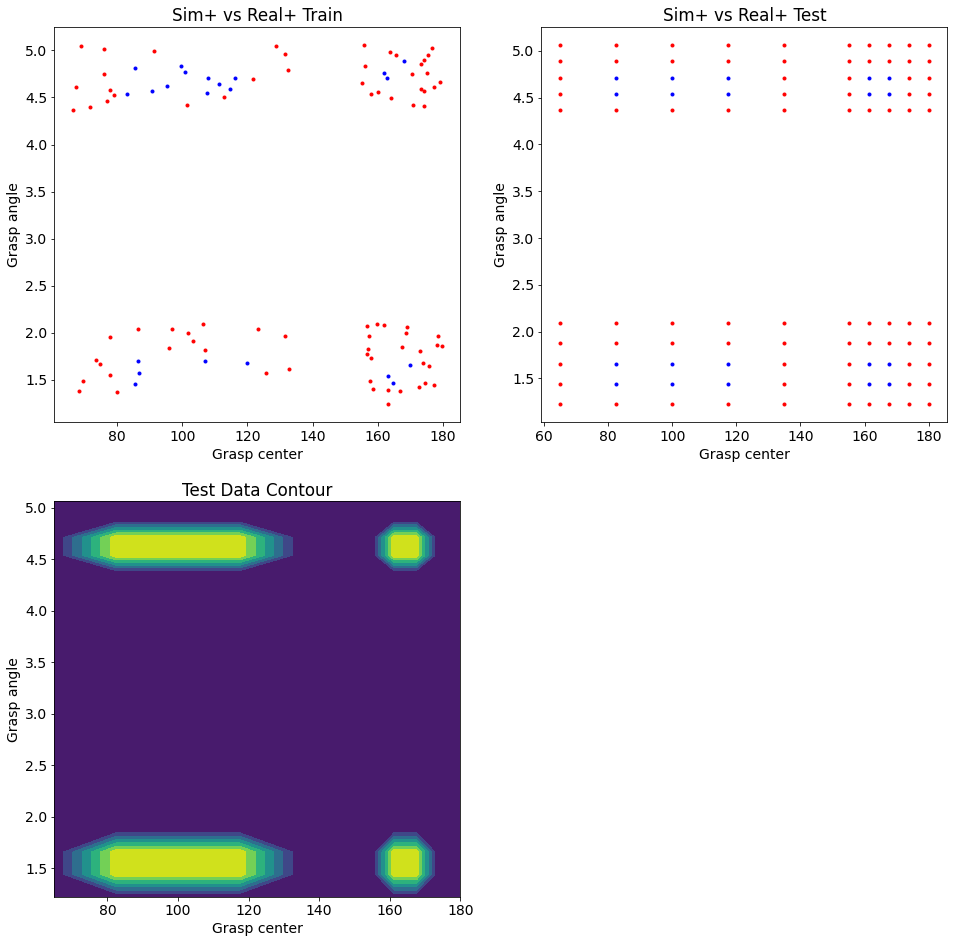

In [2]:
# USING 2D FORK DATA ===============================

n = 10

# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=100, is_pos_label=True, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=n, is_pos_label=True, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)



# dataset = ToyGraspDataset(root='data', size=50)
train_x = torch.Tensor(train_dataset.data[:,:2])
train_y = torch.Tensor(train_dataset.data[:,2]).long()
x_t = train_x.clone()
# Normalize inputs
x_t[:,0] /= 244
x_t[:,1] /= (3.14*2)

y = train_dataset.data[:,2].reshape(-1,1)

test_x = torch.Tensor(test_dataset.data[:,:2])
# test_x = torch.Tensor(test_dataset.data[:,:2])
test_x_mat = torch.reshape(test_x[:,0], (n, n))
test_y_mat = torch.reshape(test_x[:,1], (n, n))

test_y = torch.Tensor(test_dataset.data[:,2]).long()
test_labels = torch.reshape(test_y, (n, n))





fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)

# show the data
data = train_dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks

ax1.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax1.set_title('Sim+ vs Real+ Train')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')





ax2 = fig.add_subplot(222)
test_pos_masks = test_y == 1
test_neg_masks = ~test_pos_masks

ax2.scatter(test_x[test_pos_masks][:,0], test_x[test_pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax2.scatter(test_x[test_neg_masks][:,0], test_x[test_neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax2.set_title('Sim+ vs Real+ Test')
ax2.set_xlabel('Grasp center')
ax2.set_ylabel('Grasp angle')





ax3 = fig.add_subplot(223)
ax3.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax3.set_title('Test Data Contour')
ax3.set_xlabel('Grasp center')
ax3.set_ylabel('Grasp angle')






plt.show()

In [7]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel



# We will use the simplest form of GP model, exact inference
class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF'):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if kernel == 'RBF':
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        elif kernel == 'RQ':
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# import os
# smoke_test = ('CI' in os.environ)
# training_iter = 2 if smoke_test else 100


# # Find optimal model hyperparameters
# model.train()
# likelihood.train()

# # Use the adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# # "Loss" for GPs - the marginal log likelihood
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# for i in range(training_iter):
#     # Zero gradients from previous iteration
#     optimizer.zero_grad()
#     # Output from model
#     output = likelihood(model(x_t))
# #     print(output.loc[:10])
    
#     # Calc loss and backprop gradients
# #     loss = -mll(output, likelihood.transformed_targets).sum()
#     loss = -mll(output, train_y).sum()
# #     loss = -mll(output, ytrain_tensor)

#     loss.backward()

# #     train_accuracy = (torch.round(output.loc.clone()) == train_y).sum().item()
    
#     if i % 10 == 0:

#         print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#             i + 1, training_iter, loss.item(),
#             model.covar_module.base_kernel.lengthscale.item(),
#             model.likelihood.noise.item()
#         ))        
# #         print('Iter %d/%d - Loss: %.3f - Acc: %.3f' % (i + 1, training_iter, loss.item(), train_accuracy))
# #         print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
#     optimizer.step()

Iter 1/100 - Loss: 1.176   lengthscale: 0.693   noise: 0.693
Iter 11/100 - Loss: 0.845   lengthscale: 1.282   noise: 0.313
Iter 21/100 - Loss: 0.595   lengthscale: 1.819   noise: 0.131
Iter 31/100 - Loss: 0.565   lengthscale: 1.951   noise: 0.069
Iter 41/100 - Loss: 0.560   lengthscale: 1.585   noise: 0.071
Iter 51/100 - Loss: 0.549   lengthscale: 1.067   noise: 0.091
Iter 61/100 - Loss: 0.545   lengthscale: 0.618   noise: 0.092
Iter 71/100 - Loss: 0.533   lengthscale: 0.238   noise: 0.082
Iter 81/100 - Loss: 0.489   lengthscale: 0.047   noise: 0.075
Iter 91/100 - Loss: 0.431   lengthscale: 0.026   noise: 0.056


In [12]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_t, train_y, likelihood, kernel='RQ')


# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = likelihood(model(x_t))
    
    # Calc loss and backprop gradients
    loss = -mll(output, train_y).sum()
    loss.backward()
    
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))        
    optimizer.step()
    

Iter 1/100 - Loss: 1.176   lengthscale: 0.693   noise: 0.693
Iter 11/100 - Loss: 0.845   lengthscale: 1.282   noise: 0.313
Iter 21/100 - Loss: 0.595   lengthscale: 1.819   noise: 0.131
Iter 31/100 - Loss: 0.565   lengthscale: 1.951   noise: 0.069
Iter 41/100 - Loss: 0.560   lengthscale: 1.585   noise: 0.071
Iter 51/100 - Loss: 0.549   lengthscale: 1.067   noise: 0.091
Iter 61/100 - Loss: 0.545   lengthscale: 0.618   noise: 0.092
Iter 71/100 - Loss: 0.533   lengthscale: 0.238   noise: 0.082
Iter 81/100 - Loss: 0.489   lengthscale: 0.047   noise: 0.075
Iter 91/100 - Loss: 0.431   lengthscale: 0.026   noise: 0.056


In [13]:
Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())
info = {}
info["pos_samples_size"] = Nq
info["neg_samples_size"] = Np

# save_model_info(model, info, name='GP_rbf')
save_model_info(model, info, name='GP_rq')


In [14]:
steps_refinement = 100


# from the GP classifier
# f2
# Nq = info2['pos_samples_size'], Np = info2['neg_samples_size']

Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())

# print(my_sample)
# my_sample = torch.FloatTensor([[25, 0.3],
my_sample = torch.FloatTensor([[60, 1.5],
                               [210, 3]])#[160, 3]
# my_sample = torch.FloatTensor([[210, 3]])

my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)


model.to(device)
model.eval()
likelihood.to(device)
likelihood.eval()

all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, likelihood, steps=steps_refinement,
# all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, steps=steps_refinement,
#                                eta=0.0001, noise_factor=0.0000,
                               eta=0.1, noise_factor=0.000,
#                                eta=0.5, noise_factor=0.000,
                              Nq = Nq, Np = Np)

22 78
22 78


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0.46642277 0.7441971


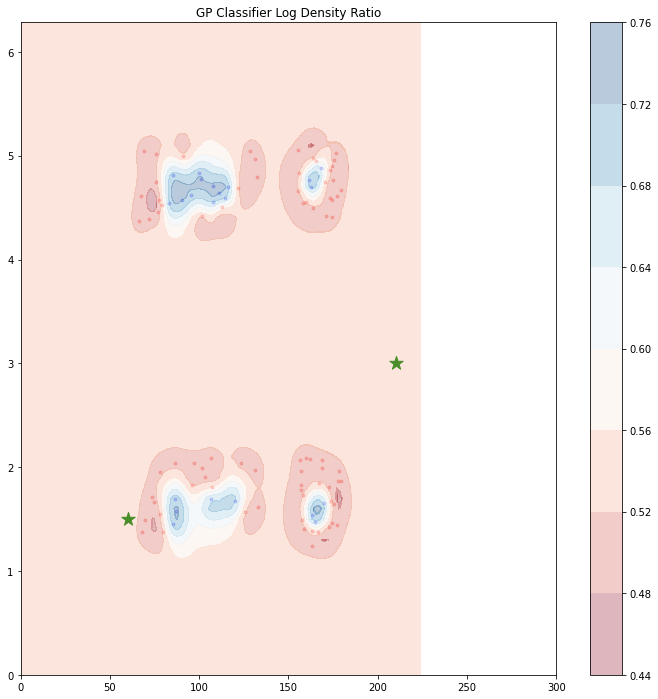

In [15]:

import torch
torch.cuda.empty_cache()
fig, ax = plt.subplots(nrows=1, figsize=(12,12))
ax.scatter(train_x[pos_masks][:,0], train_x[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(train_x[neg_masks][:,0], train_x[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# plt.scatter(my_sample[:, 0], my_sample[:,1], marker='*', color='g', s=200)

for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)
#     plt.scatter(all_x1[i][:, 0], all_x1[i][:,1], marker='d', color='g', s=4)


Z, CS = draw_density_ratio_GP(ax=ax,
                   model=model,
                   likelihood=likelihood,
                   p_type='p_y_given_x',
#                    p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=Np, Nq=Nq)
fig.colorbar(CS, ax=ax)



ax.set_title(f'GP Classifier Log Density Ratio')
ax.set_xlim([0, 300])
ax.set_ylim([0, 2*np.pi])

plt.show()

# Refining Multiple Grasps

1. Create test dataset
2. Refine datapoints
    - using single refinement
    - using corrector refinement
3. create graph/table

real_refine!!


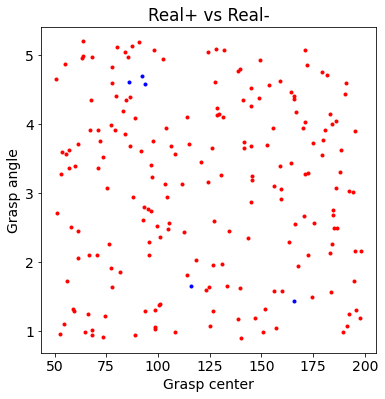

In [25]:
from dataset import ToyGraspDataset
# real_dataset = ToyGraspDataset(root='data', size=10000, is_pos_label=True, device=device)
real_dataset = ToyGraspDataset(root='data', name='real_refine', size=200, is_pos_label=True, device=device)

# show the data
real_data = real_dataset.data
real_pos_masks = real_data[:,2] == 1
real_neg_masks = ~real_pos_masks
n_orig_pos = np.sum(real_pos_masks)


fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.scatter(real_data[real_pos_masks][:,0], real_data[real_pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.scatter(real_data[real_neg_masks][:,0], real_data[real_neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax1.set_title('Real+ vs Real-')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')

plt.show()

real_data = torch.tensor(real_data[:,:2])
real_data[:,0] /= 224
real_data[:,1] /= (2*3.14)

all_data = {}

In [26]:
# load pos vs neg classifier
f1 = ClassifierNN([2, 64, 64, 1])
f1, info1 = load_model_info('pos_vs_neg', f1)
f1 = f1.to(device)
all_data['f1'] = f1
all_data['info1'] = info1

In [27]:
# load sim+ vs sim- classifier
f2 = ClassifierNN([2, 32, 32, 1])
f2, info2 = load_model_info('sim_vs_real_1k', f2)
# f2, info2 = load_model_info('sim_vs_real_2.5k', f2)
# f2, info2 = load_model_info('sim_vs_real_1k', f2)

f2 = f2.to(device)
all_data['f2'] = f2
all_data['info2'] = info2

In [28]:
l4 = gpytorch.likelihoods.GaussianLikelihood()
f4 = ExactGPModel(x_t, train_y, l4, kernel='RBF')
f4, info4 = load_model_info('GP_rbf', f4)

f4 = f4.to(device)
l4 = l4.to(device)
f4.eval()
l4.eval()
all_data['f4'] = f4
all_data['l4'] = l4
all_data['info4'] = info4

In [29]:
l5 = gpytorch.likelihoods.GaussianLikelihood()
f5 = ExactGPModel(x_t, train_y, l5, kernel='RQ')
f5, info5 = load_model_info('GP_rq', f5)

f5 = f5.to(device)
l5 = l5.to(device)
f5.eval()
l5.eval()
all_data['f5'] = f5
all_data['l5'] = l5
all_data['info5'] = info5

In [30]:
# set refinement parameters
f_div = 'KL'
steps_refinement = 100

## Classifier + NN Corrector Refinement

In [31]:
all_x1, all_v1 = refine_sample2(real_data.to(device), f1, f2,
                                steps=steps_refinement,
#                                 steps=150,
                                f=f_div,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info1['neg_samples_size'],
                                Nq1=info1['pos_samples_size'],
                                Np2=info2['neg_samples_size'],
                                Nq2=info2['pos_samples_size']
                                )
# all_x8 = torch.cat(all_x8).numpy()

refined_points = all_x1[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_refined_pos, pos_mask = count_real_positives(refined_points)
all_data['pos_mask_1'] = pos_mask
all_data['all_x1'] = all_x1
all_data['all_v1'] = all_v1
all_data['n_pos_1'] = n_refined_pos

print(n_orig_pos)
print(n_refined_pos)

  0%|          | 0/100 [00:00<?, ?it/s]

5
32


## Classifier + GP RBF Corrector Refinement

In [32]:
all_x_GP, all_v_GP = refine_sample2_GP(real_data.to(device), f1, f4, likelihood,
                                steps=steps_refinement,
#                                 steps=150,
                                f=f_div,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info1['neg_samples_size'],
                                Nq1=info1['pos_samples_size'],
                                Np2=info4['neg_samples_size'],
                                Nq2=info4['pos_samples_size']
                                )
# all_x8 = torch.cat(all_x8).numpy()

refined_points = all_x_GP[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_refined_pos, pos_mask = count_real_positives(refined_points)
all_data['pos_mask_2'] = pos_mask

all_data['all_x2'] = all_x_GP
all_data['all_v2'] = all_v_GP
all_data['n_pos_2'] = n_refined_pos


print(n_orig_pos)
print(n_refined_pos)

  0%|          | 0/100 [00:00<?, ?it/s]

5
64


In [33]:
all_x_GP, all_v_GP = refine_sample2_GP(real_data.to(device), f1, f5, likelihood,
                                steps=steps_refinement,
#                                 steps=150,
                                f=f_div,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info1['neg_samples_size'],
                                Nq1=info1['pos_samples_size'],
                                Np2=info4['neg_samples_size'],
                                Nq2=info4['pos_samples_size']
                                )
# all_x8 = torch.cat(all_x8).numpy()

refined_points = all_x_GP[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_refined_pos, pos_mask = count_real_positives(refined_points)
all_data['pos_mask_3'] = pos_mask

all_data['all_x3'] = all_x_GP
all_data['all_v3'] = all_v_GP
all_data['n_pos_3'] = n_refined_pos


print(n_orig_pos)
print(n_refined_pos)

  0%|          | 0/100 [00:00<?, ?it/s]

5
65


0.0 1.0
ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (raw_outputscale_constraint): Positive()
  )
)
{'pos_samples_size': 22, 'neg_samples_size': 78}


  0%|          | 0/10 [00:00<?, ?it/s]

0.4863374 0.72288597
ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RQKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_alpha_constraint): Positive()
      (distance_module): Distance()
    )
    (raw_outputscale_constraint): Positive()
  )
)
{'pos_samples_size': 22, 'neg_samples_size': 78}


  0%|          | 0/10 [00:00<?, ?it/s]

0.46642277 0.7441971


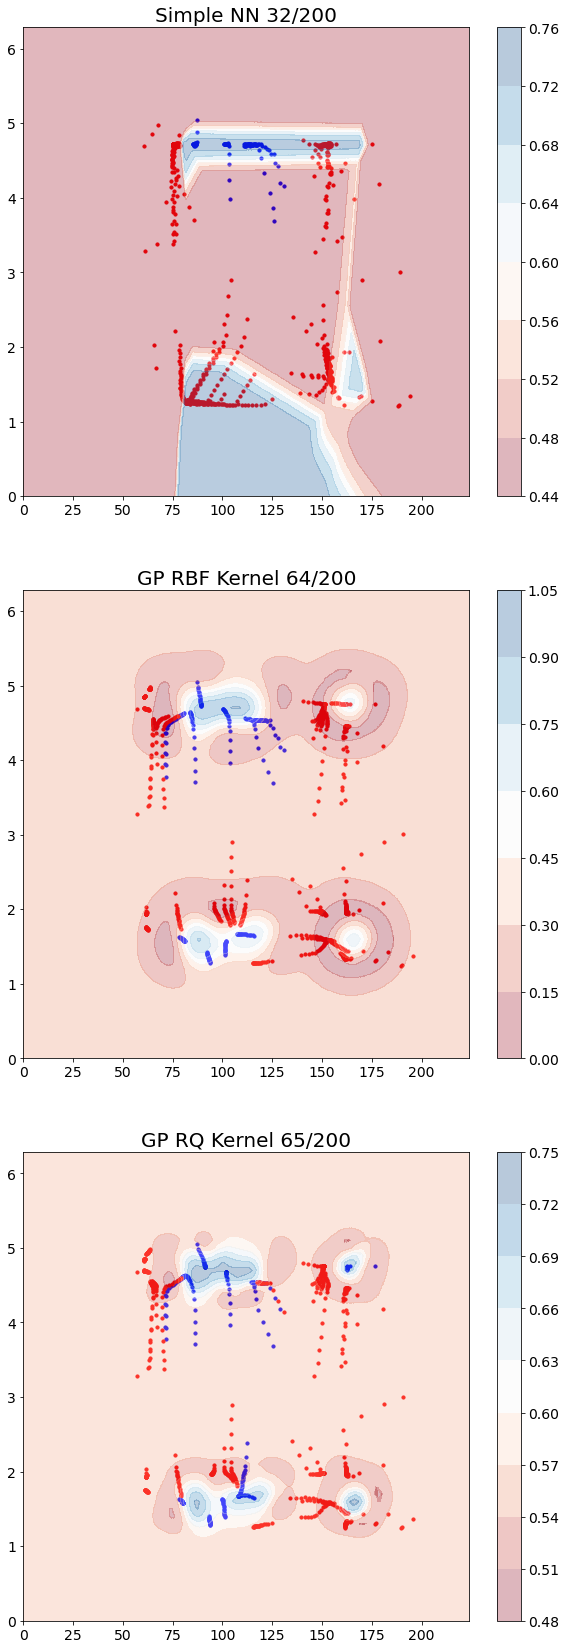

In [34]:
colors = ['b','g','r','c','m','y','k','w']
titles = ['',
          'Simple NN',
          'GP RBF Kernel',
          'GP RQ Kernel',
          'GP RBF Kernel'
         ]

fig = plt.figure(figsize=(10,50))

for a in range(1,4):
    ax = fig.add_subplot(int(f'51{a}'))

    fig.colorbar(CS, ax=ax)
    ax.set_xlim([0, 224])
    ax.set_ylim([0, 2*np.pi])
                         
    pos_mask = all_data[f'pos_mask_{a}']
#     neg_mask = ~pos_mask
                         
    for i in range(50):
        for j in range(1, steps_refinement, 5):
            if pos_mask[i]==True:
                ax.scatter(all_data[f'all_x{a}'][j][i, 0]*224, all_data[f'all_x{a}'][j][i,1]*(2*3.14), marker='o', color='b', s=10)
            else:
                ax.scatter(all_data[f'all_x{a}'][j][i, 0]*224, all_data[f'all_x{a}'][j][i,1]*(2*3.14), marker='o', color='r', s=10)

#     info = None
    
    if a==1:
        f = all_data['f2']
        info = all_data['info2']
         
                         
        Z, CS = draw_density_ratio(ax=ax,
                           model=f,
                           p_type='p_y_given_x',
                           device=device,
                           x_lim=[0, 224],
                           y_lim=[0, 2*np.pi],
                           cmap='RdBu',
                           step_size=0.05,
                           Np=info['neg_samples_size'], Nq=info['pos_samples_size'])
    elif a>1:
        f = all_data[f'f{a+2}']
        l = all_data[f'l{a+2}']
        info = all_data[f'info{a+2}']    
        print(f)
        print(info)
        Z, CS = draw_density_ratio_GP(ax=ax,
                           model=f,
                           likelihood=l,
                           p_type='p_y_given_x',
                           device=device,
                           x_lim=[0, 224],
                           y_lim=[0, 2*np.pi],
                           cmap='RdBu',
                           step_size=0.1,
                           Np=info['neg_samples_size'],
                           Nq=info['pos_samples_size'])

    ax.set_title(f"{titles[a]} {all_data[f'n_pos_{a}']}/{real_data.size(0)}", fontsize=20)
    


plt.show()